<a href="https://colab.research.google.com/github/nadaa-medhat1/Damage-Detection-YOLOV8/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Fri Feb 28 15:34:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [5]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.7/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="lRCaQ9UNobJwzjZovMTR")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(25)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-Site-Safety-25 in yolov11:: 100%|██████████| 5546/5546 [00:00<00:00, 5926.65it/s]


## Custom Training

In [7]:
import os
import shutil
import json
import random
from collections import defaultdict
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import drive


# ---------------------------
# الخطوة 2: تصفية البيانات
# ---------------------------
def filter_dataset(dataset_path, max_samples=1000):
    classes_to_keep = {5, 6, 8, 9}  # Person, Safety Cone, machinery, vehicle
    filtered_path = f"{dataset_path}_filtered"

    # إنشاء هيكل المجلدات
    for split in ['train', 'valid', 'test']:
        os.makedirs(os.path.join(filtered_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(filtered_path, split, 'labels'), exist_ok=True)

    class_instances = defaultdict(list)

    # جمع العينات لكل فئة
    for split in ['train', 'valid', 'test']:
        labels_dir = os.path.join(dataset_path, split, 'labels')
        if not os.path.exists(labels_dir):
            continue

        for filename in os.listdir(labels_dir):
            if filename.endswith('.txt'):
                file_info = {'filename': filename, 'split': split, 'classes': set()}
                with open(os.path.join(labels_dir, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split()[0])
                        if class_id in classes_to_keep:
                            file_info['classes'].add(class_id)
                            class_instances[class_id].append(file_info)

    # اختيار العينات العشوائية
    selected_files = set()
    for class_id in classes_to_keep:
        instances = class_instances[class_id]
        random.shuffle(instances)
        selected = instances[:max_samples]
        for file_info in selected:
            selected_files.add((file_info['split'], file_info['filename']))

    # نسخ الملفات المختارة
    filtered_counts = defaultdict(int)
    total_processed = 0

    for split, filename in selected_files:
        labels_dir = os.path.join(dataset_path, split, 'labels')
        images_dir = os.path.join(dataset_path, split, 'images')
        image_name = filename.replace('.txt', '.jpg')

        # معالجة الملفات
        new_annotations = []
        with open(os.path.join(labels_dir, filename), 'r') as f:
            for line in f:
                parts = line.split()
                class_id = int(parts[0])
                if class_id in classes_to_keep:
                    new_class_id = list(sorted(classes_to_keep)).index(class_id)
                    new_line = f"{new_class_id} {' '.join(parts[1:])}\n"
                    new_annotations.append(new_line)
                    filtered_counts[class_id] += 1

        # نسخ الصور والملفات
        shutil.copy(
            os.path.join(images_dir, image_name),
            os.path.join(filtered_path, split, 'images', image_name)
        )

        with open(os.path.join(filtered_path, split, 'labels', filename), 'w') as f:
            f.writelines(new_annotations)

        total_processed += 1
        if total_processed % 100 == 0:
            print(f"تم معالجة {total_processed} صورة...")

    # إنشاء ملف data.yaml
    yaml_content = f"""path: {os.path.abspath(filtered_path)}
train: {os.path.abspath(os.path.join(filtered_path, 'train', 'images'))}
val: {os.path.abspath(os.path.join(filtered_path, 'valid', 'images'))}
test: {os.path.abspath(os.path.join(filtered_path, 'test', 'images'))}

nc: 4
names:
- Person
- Safety Cone
- machinery
- vehicle"""

    with open(os.path.join(filtered_path, 'data.yaml'), 'w') as f:
        f.write(yaml_content)

    # حفظ الإحصائيات
    stats = {
        'filtered_counts': {
            'Person': filtered_counts[5],
            'Safety Cone': filtered_counts[6],
            'machinery': filtered_counts[8],
            'vehicle': filtered_counts[9]
        },
        'total_images': total_processed,
        'max_samples_per_class': max_samples,
        'dataset_path': os.path.abspath(filtered_path)
    }

    with open(os.path.join(filtered_path, 'statistics.json'), 'w') as f:
        json.dump(stats, f, indent=4)

    print("\nالنتائج النهائية:")
    for class_name, count in stats['filtered_counts'].items():
        print(f"{class_name}: {count} عينة")
    print(f"\nإجمالي الصور بعد التصفية: {total_processed}")
    print(f"\nمسار مجموعة البيانات: {os.path.abspath(filtered_path)}")

    return stats

# ---------------------------
# الخطوة 3: تدريب النموذج
# ---------------------------
#def train_model():
    #drive.mount('/content/drive')
    #DRIVE_PATH = "/content/drive/MyDrive/Construction_Models2/"
filter_dataset(dataset_path="/content/datasets/Construction-Site-Safety-25")

تم معالجة 100 صورة...
تم معالجة 200 صورة...
تم معالجة 300 صورة...
تم معالجة 400 صورة...
تم معالجة 500 صورة...
تم معالجة 600 صورة...
تم معالجة 700 صورة...
تم معالجة 800 صورة...
تم معالجة 900 صورة...
تم معالجة 1000 صورة...
تم معالجة 1100 صورة...
تم معالجة 1200 صورة...
تم معالجة 1300 صورة...
تم معالجة 1400 صورة...
تم معالجة 1500 صورة...
تم معالجة 1600 صورة...
تم معالجة 1700 صورة...

النتائج النهائية:
Person: 6809 عينة
Safety Cone: 2915 عينة
machinery: 3777 عينة
vehicle: 1390 عينة

إجمالي الصور بعد التصفية: 1742

مسار مجموعة البيانات: /content/datasets/Construction-Site-Safety-25_filtered


{'filtered_counts': {'Person': 6809,
  'Safety Cone': 2915,
  'machinery': 3777,
  'vehicle': 1390},
 'total_images': 1742,
 'max_samples_per_class': 1000,
 'dataset_path': '/content/datasets/Construction-Site-Safety-25_filtered'}

In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11l.pt data=/content/datasets/Construction-Site-Safety-25_filtered/data.yaml epochs=100 imgsz=640 plots=True

/content
100% 49.0M/49.0M [00:01<00:00, 43.8MB/s]
New https://pypi.org/project/ultralytics/8.3.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/datasets/Construction-Site-Safety-25_filtered/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, a

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [9]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      train_batch9540.jpg
confusion_matrix.png				    R_curve.png       train_batch9541.jpg
events.out.tfevents.1740756996.d663c39c2a3c.2120.0  results.csv       train_batch9542.jpg
F1_curve.png					    results.png       val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg  val_batch0_pred.jpg
labels.jpg					    train_batch1.jpg  weights


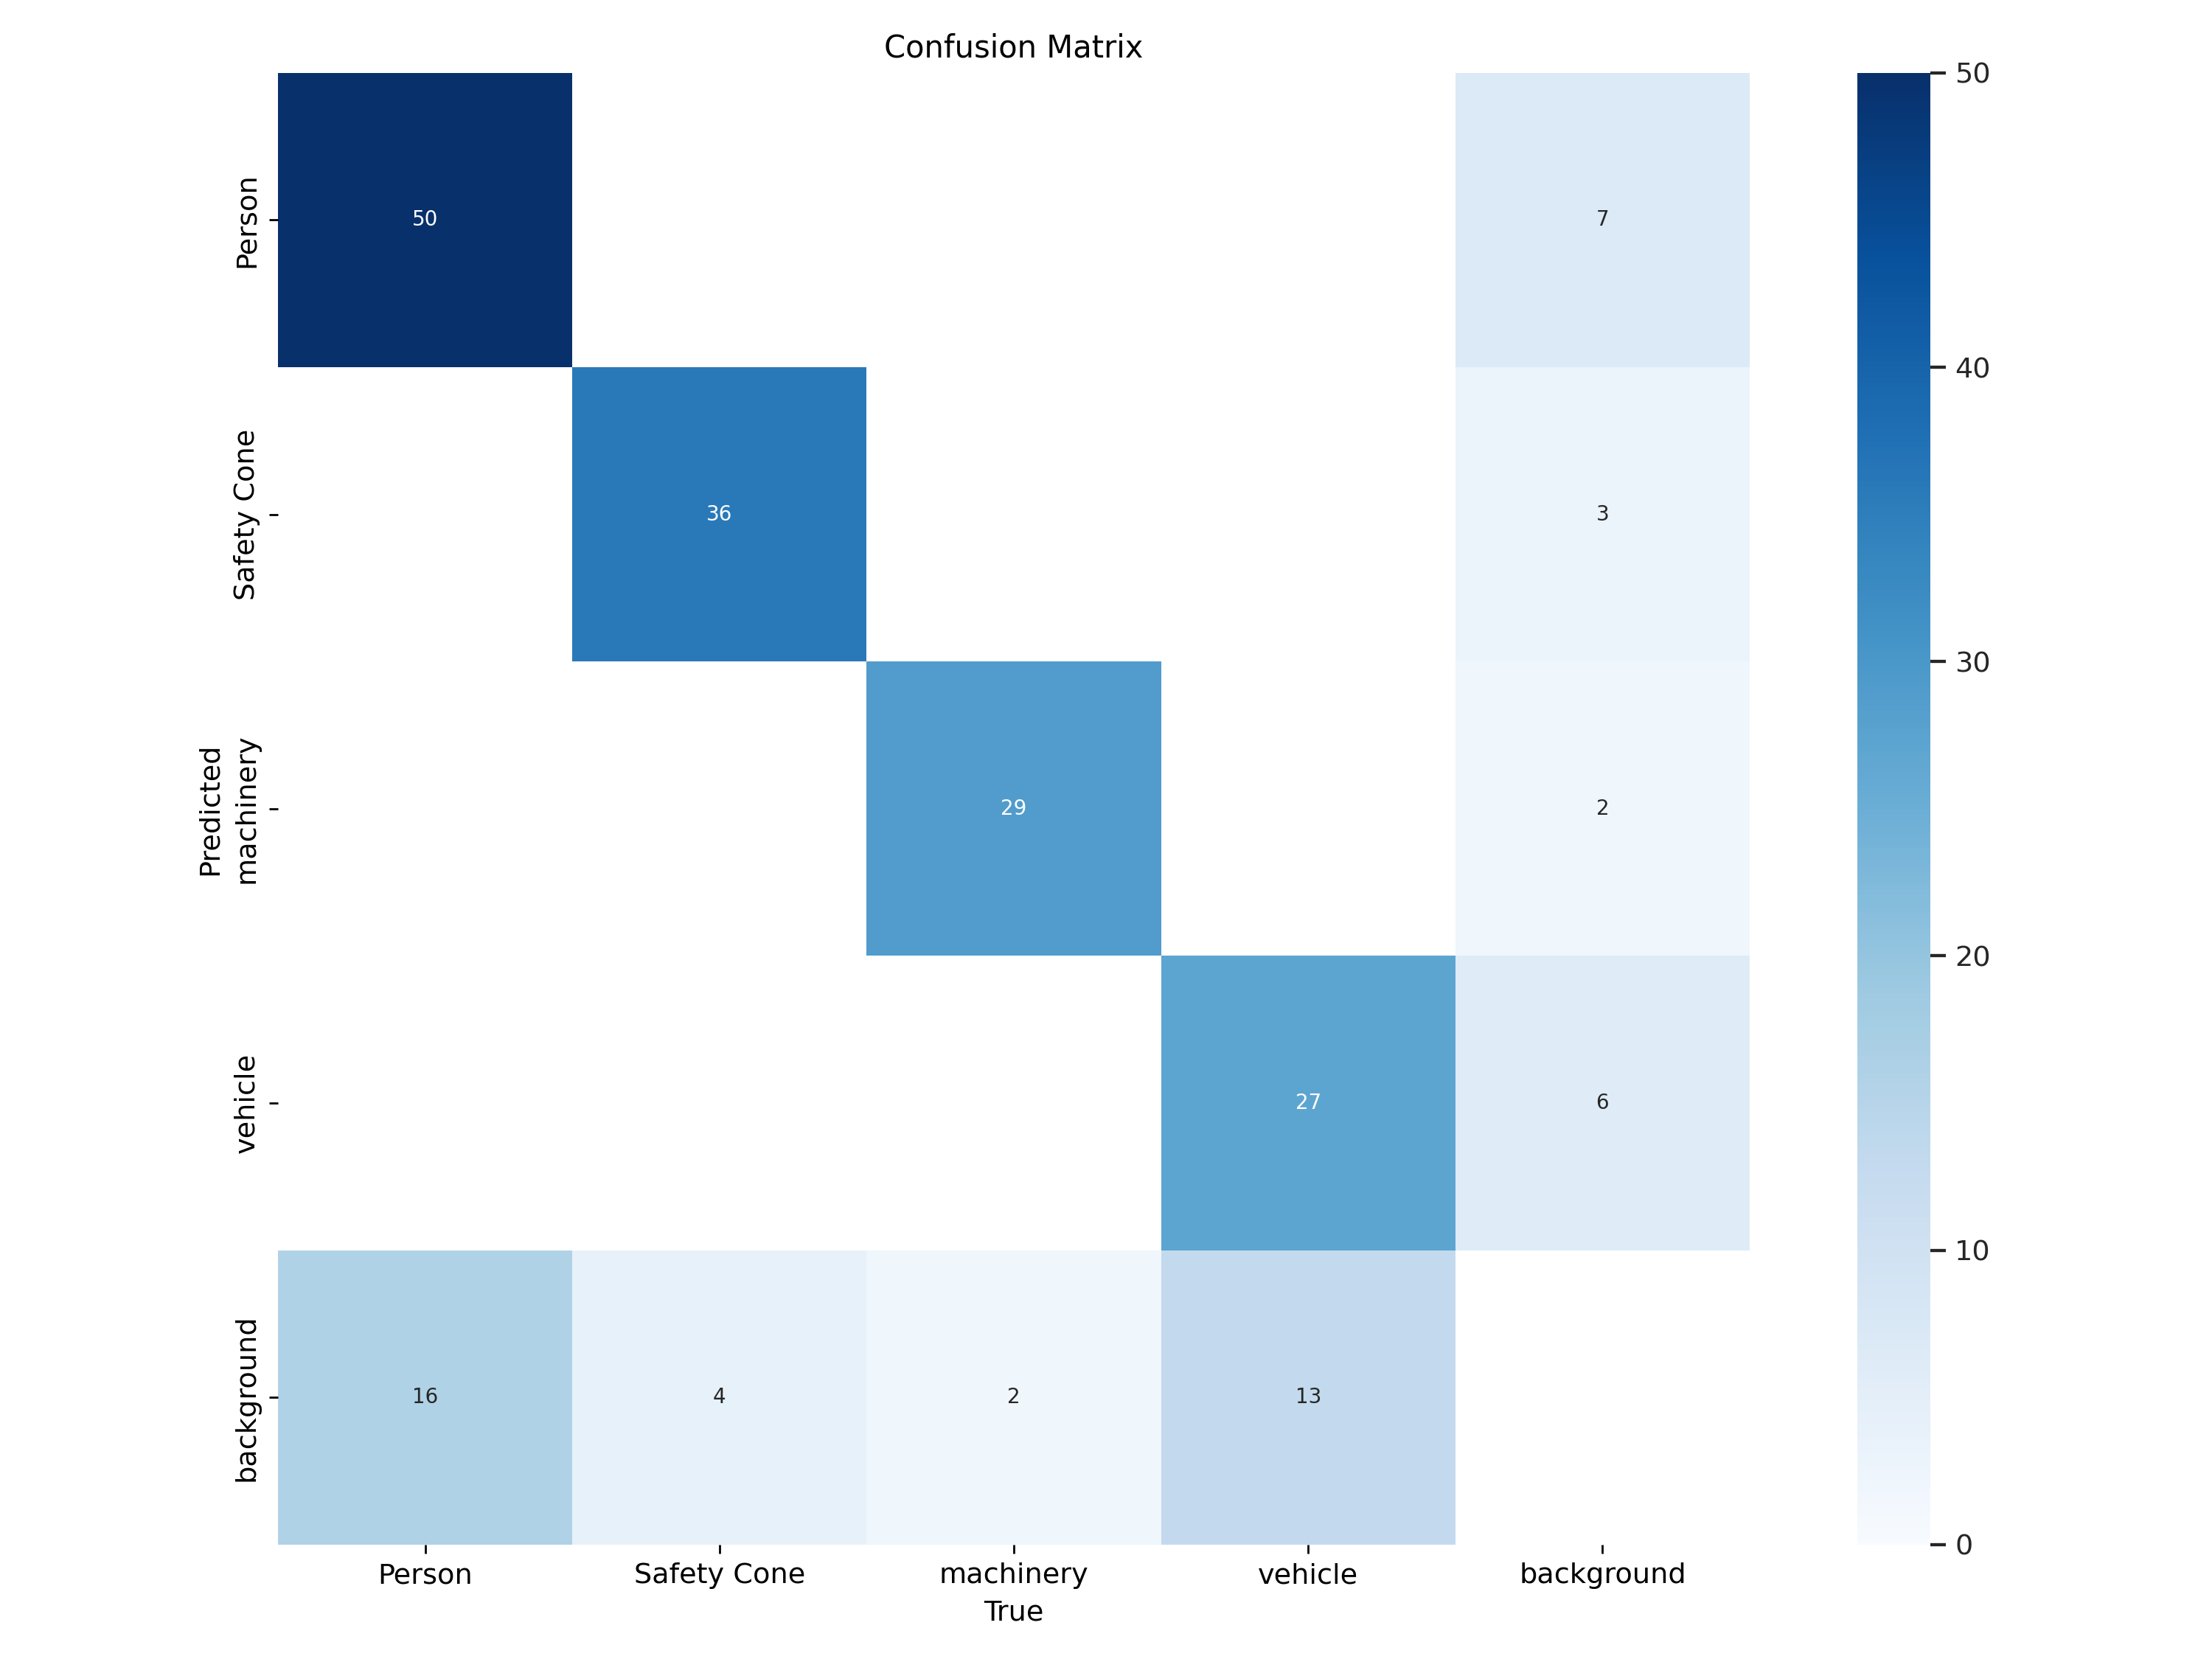

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

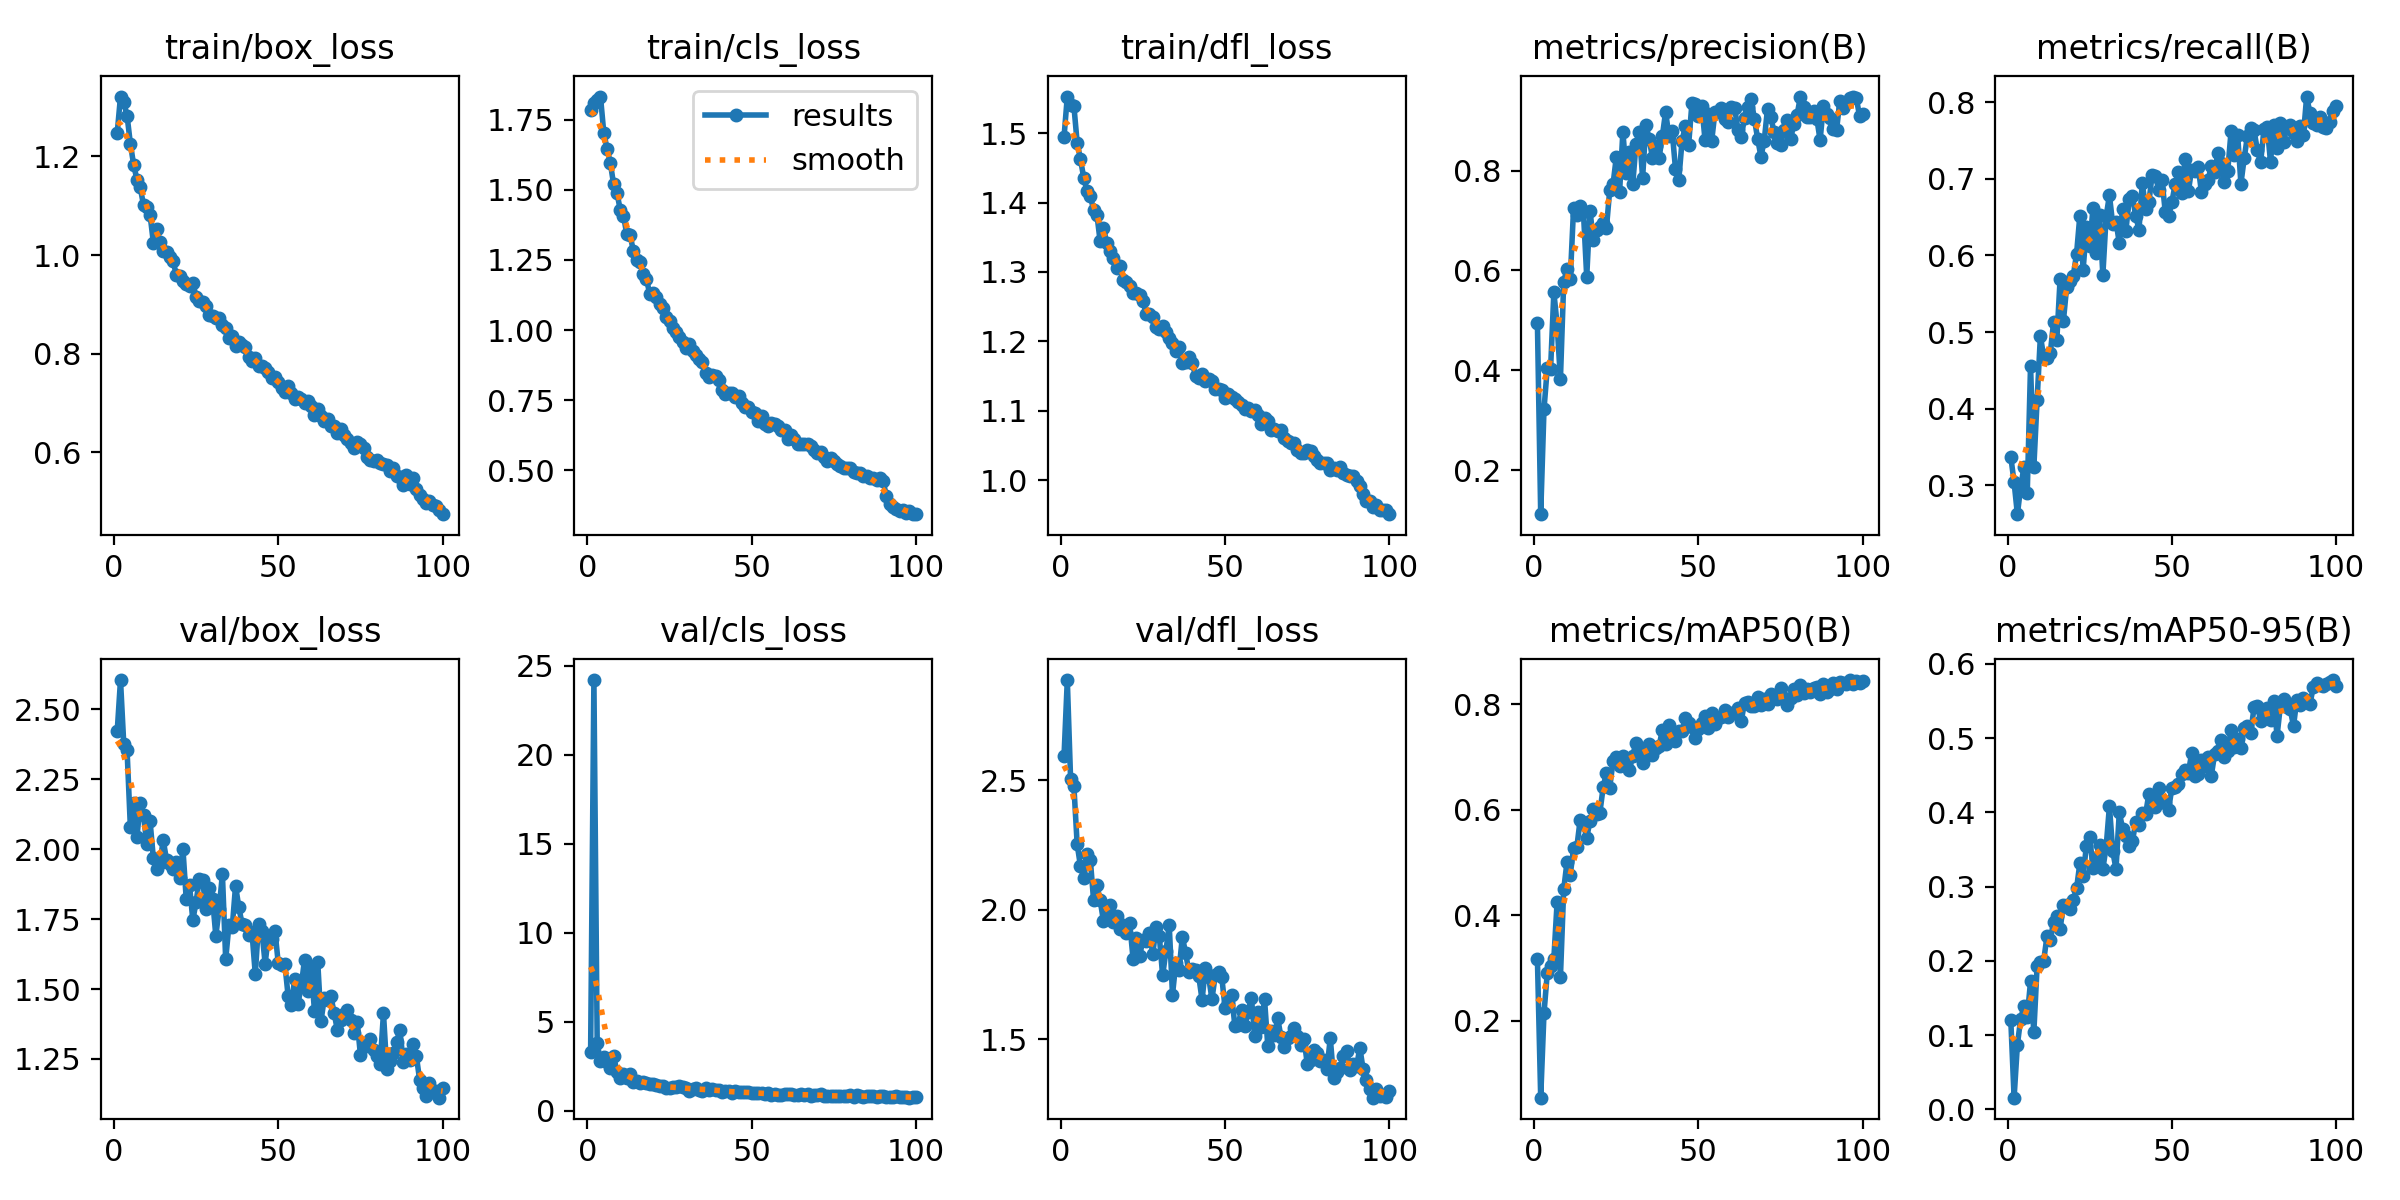

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

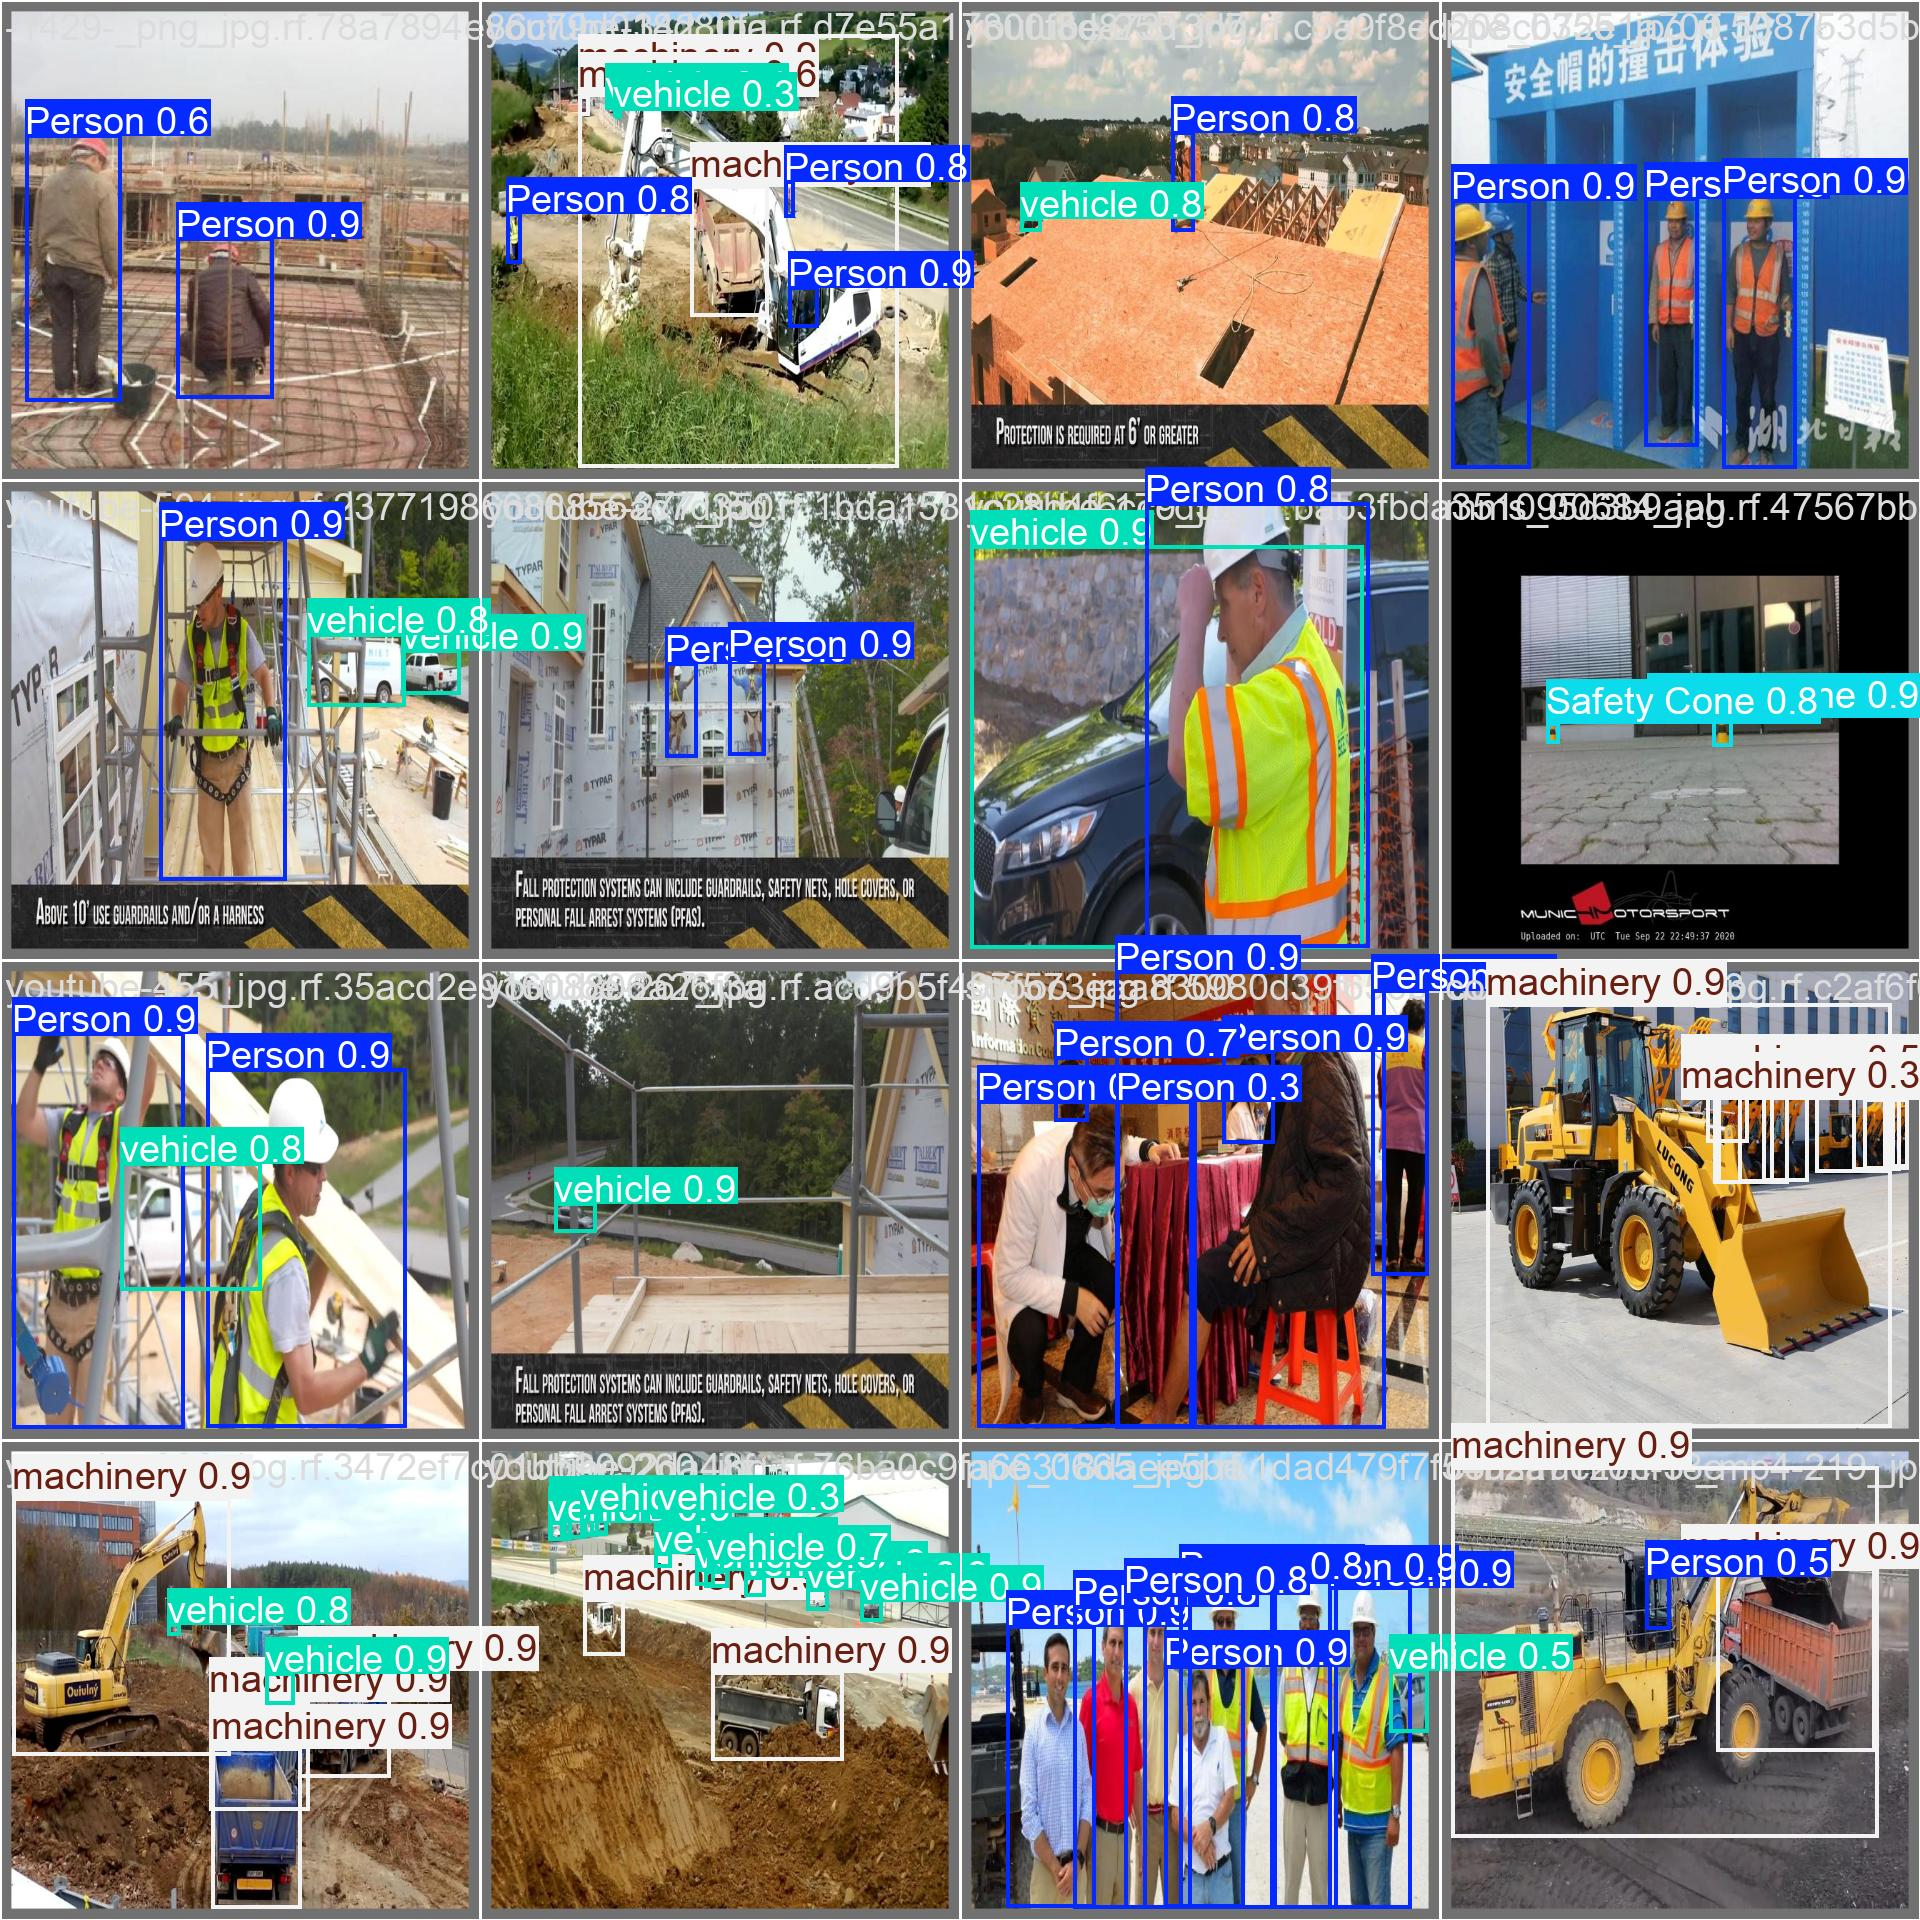

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [13]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 464 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Scanning /content/datasets/Construction-Site-Safety-25/valid/labels... 113 images, 10 backgrounds, 0 corrupt: 100% 113/113 [00:00<00:00, 2364.89it/s]
val: New cache created: /content/datasets/Construction-Site-Safety-25/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/8 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 972, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 638, in val
    validator(model=self.model)
  F

## Inference with custom model

In [14]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 464 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs

image 1/79 /content/datasets/Construction-Site-Safety-25/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Person, 47.4ms
image 2/79 /content/datasets/Construction-Site-Safety-25/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Persons, 40.6ms
image 3/79 /content/datasets/Construction-Site-Safety-25/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Persons, 1 machinery, 40.5ms
image 4/79 /content/datasets/Construction-Site-Safety-25/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Person, 1 Safety Cone, 2 vehicles, 40.6ms
image 5/79 /content/datasets/Construction-Site-Safety-25/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 7 Persons, 40.5ms
image 6/79 /content/datasets/Construction-Site-Safety-2

**NOTE:** Let's take a look at few results.

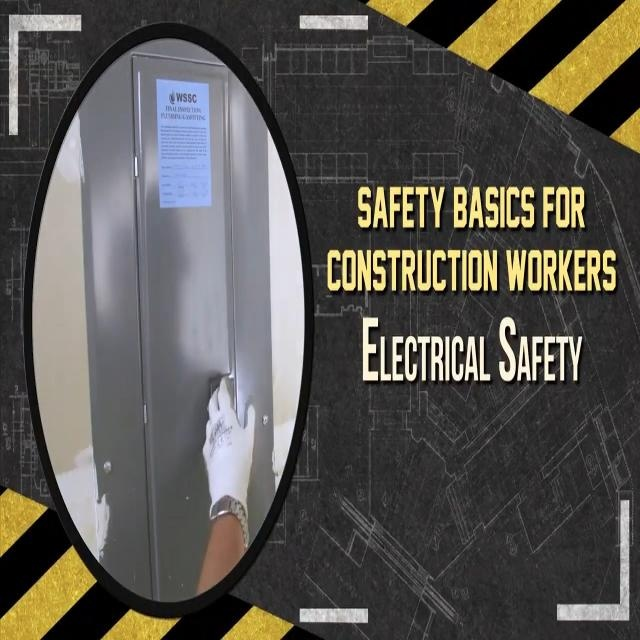

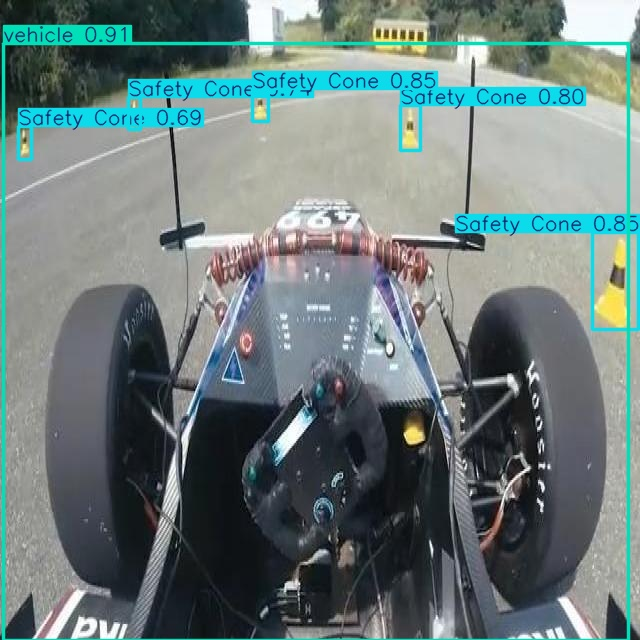

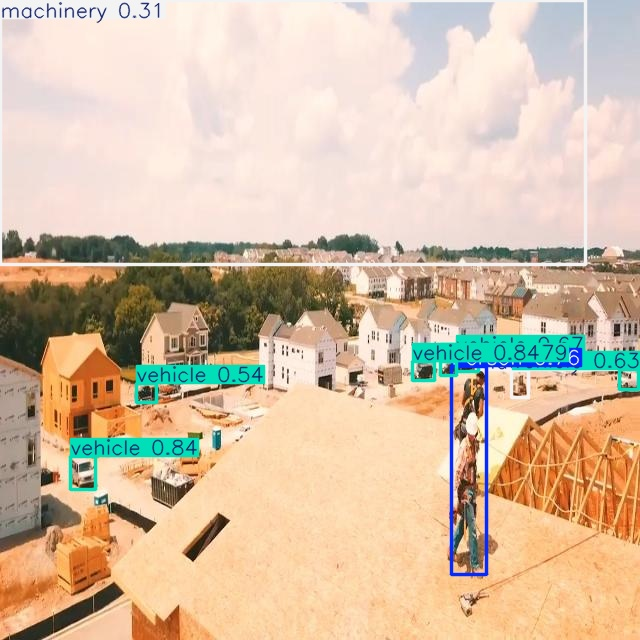

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [16]:
# prompt: locate drive then

import os
from google.colab import drive

# Check if the directory exists and is empty
if os.path.exists('/content/drive/MyDrive') and os.listdir('/content/drive/MyDrive'):
  # If it's not empty, prompt the user to confirm they want to overwrite
  print("Warning: /content/drive/MyDrive is not empty. Mounting may overwrite existing files.")
  confirmation = input("Do you want to continue? (y/n): ")
  if confirmation.lower() != 'y':
    print("Mounting aborted.")
    # You might want to add logic here to handle the situation
    # where the user doesn't want to overwrite
else:
  # If it's empty or doesn't exist, proceed with mounting
  drive.mount('/content/drive/MyDrive')

ValueError: Mountpoint must be in a directory that exists

In [18]:
# prompt:  save all result and runs files  and download it

import shutil
import os

# Define the source directory (where your files are currently located)
source_dir = "/content/runs"  # Replace with the actual path if different

# Define the destination directory (where you want to zip the files)
destination_dir = "/content/drive/MyDrive"  # Replace with your desired location in Google Drive

# Create a zip archive of the source directory
shutil.make_archive(os.path.join(destination_dir, "yolo11l_results"), 'zip', source_dir)

print(f"Files zipped and saved to: {destination_dir}/yolo11l_results.zip")

Files zipped and saved to: /content/drive/MyDrive/yolo11l_results.zip


## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.